
# 🧠 Project Summary: Predicting Tau Positivity for Clinical Trial Triage

This project aims to develop a clinically meaningful machine learning model to **triage clinical trial patients based on tau protein positivity**, defined as a **tTau/Aβ₄₂ ratio > 0.27**. The objective is to support early decision-making in trial recruitment by leveraging **multimodal biomarkers**, including cognitive scores, APOE4 status, and MRI-derived features.

---

## 🔧 Workflow Overview

### 1. Data Preprocessing
- Cleaned and standardized clinical data, including handling of biologically implausible values (e.g., `>1700` in ABETA).
- Addressed missing values using appropriate imputation strategies.

### 2. Feature Engineering
- Created biologically and clinically informative derived features:
  - **Biomarker ratios**: tTau/Aβ, pTau/Aβ
  - **Normalized MRI volumes** (e.g., hippocampus/ICV)
  - **Interaction terms**: APOE4 × Age, Cognitive scores × MRI
  - **Composite cognitive scores** to capture memory and executive function

### 3. Model Development and Evaluation
- Trained and compared three models:
  - **Logistic Regression**
  - **Random Forest**
  - **XGBoost** (best-performing)
- Used techniques including:
  - Stratified train-test split
  - Hyperparameter tuning with `RandomizedSearchCV`
  - `scale_pos_weight` to address class imbalance
- Evaluated performance using:
  - **AUC-ROC**
  - **Precision**, **Recall**, **F1-score**, **F2-score** (with clinical emphasis on recall)

### 4. Best Model: XGBoost (Optimized Threshold)
- **AUC-ROC**: `0.859`
- **Recall (Sensitivity)**: `0.87` for tau/Aβ-positive cases
- **Classification Report:**



### 5. Model Interpretability (SHAP)
- Used **SHAP values** to interpret feature contributions.
- Top contributors:
- `ADAS13_bl`
- `APOE4_AGE`
- `Memory Composite`
- `APOE4_Hippocampus`
- Interpretability supports clinical transparency and aligns model behavior with existing literature on AD pathology.

---

## ✅ Clinical Utility

The final model shows strong potential as a **pre-screening tool** in clinical trials by effectively identifying patients with CSF tau pathology. Its high **recall** makes it particularly suitable for early triage, ensuring that fewer tau-positive patients are missed for enrollment into therapeutic studies.


In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("df_clean (2).csv")

In [3]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt


# Display basic info
print(f"Dataset shape: {df.shape}")
print("\nData types:\n", df.dtypes.value_counts())
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False))

Dataset shape: (2430, 31)

Data types:
 float64    24
object      6
int64       1
Name: count, dtype: int64

Missing values per column:
PTAU_bl                     1215
TAU_bl                      1215
ABETA_bl                    1215
AGE                            0
RID                            0
PTID                           0
DX_bl                          0
APOE4                          0
PTEDUCAT                       0
PTGENDER                       0
FDG_bl                         0
CDRSB_bl                       0
ADAS11_bl                      0
ADAS13_bl                      0
ADASQ4_bl                      0
MMSE_bl                        0
RAVLT_immediate_bl             0
RAVLT_learning_bl              0
RAVLT_forgetting_bl            0
RAVLT_perc_forgetting_bl       0
LDELTOTAL_BL                   0
TRABSCOR_bl                    0
FAQ_bl                         0
MOCA_bl                        0
Ventricles_bl                  0
Hippocampus_bl                 0
WholeB

In [4]:
#In the ABETA_bl some values are simply > 1700 upper limit, we converted these to 1700

df["ABETA_bl"] = df["ABETA_bl"].astype(str).str.replace('>', '', regex=False).str.replace('<', '', regex=False).astype(float)
df["ABETA_bl"] = df["ABETA_bl"].replace(">1700", "1700").astype(float)

In [5]:
df['TAU_bl'] = pd.to_numeric(df['TAU_bl'], errors='coerce')
df['PTAU_bl'] = pd.to_numeric(df['PTAU_bl'], errors='coerce')
df['tTau_ABETA_ratio'] = df['TAU_bl'] / df['ABETA_bl']
df['pTau_ABETA_ratio'] = df['PTAU_bl'] / df['ABETA_bl']

In [6]:
tau_cut = 0.27      # tTau/Aβ₄₂
ptau_cut = 0.025    # pTau₁₈₁/Aβ₄₂

In [7]:
df['tTau_Positive'] = (df['tTau_ABETA_ratio'] > tau_cut).astype(int)
df['pTau_Positive'] = (df['pTau_ABETA_ratio'] > ptau_cut).astype(int)

In [8]:
df.shape

(2430, 35)

In [9]:
columns_to_drop = ["RID","PTID","DX_bl","ABETA_bl","TAU_bl","PTAU_bl","pTau_ABETA_ratio","pTau_Positive"]

In [10]:
df = df.drop(columns=columns_to_drop)

In [11]:
df = df.dropna()

In [12]:
df.columns

Index(['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'FDG_bl', 'CDRSB_bl',
       'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl',
       'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl',
       'LDELTOTAL_BL', 'TRABSCOR_bl', 'FAQ_bl', 'MOCA_bl', 'Ventricles_bl',
       'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl',
       'MidTemp_bl', 'ICV_bl', 'tTau_ABETA_ratio', 'tTau_Positive'],
      dtype='object')

In [13]:
# 1. MRI Volumes Normalized by ICV (Intracranial Volume)
df['Hippocampus_ICV'] = df['Hippocampus_bl'] / df['ICV_bl']
df['Ventricles_ICV'] = df['Ventricles_bl'] / df['ICV_bl']
df['Entorhinal_ICV'] = df['Entorhinal_bl'] / df['ICV_bl']
df['Fusiform_ICV'] = df['Fusiform_bl'] / df['ICV_bl']
df['MidTemp_ICV'] = df['MidTemp_bl'] / df['ICV_bl']

# 2. Cognitive-MRI Interactions
df['Hippocampus_MMSE'] = df['Hippocampus_ICV'] * df['MMSE_bl']
df['Ventricles_CDRSB'] = df['Ventricles_ICV'] * df['CDRSB_bl']
df['Entorhinal_ADAS13'] = df['Entorhinal_ICV'] * df['ADAS13_bl']

# 3. APOE4 Interactions
df['APOE4_AGE'] = df['APOE4'] * df['AGE']
df['APOE4_EDUC'] = df['APOE4'] * df['PTEDUCAT']
df['APOE4_Hippocampus'] = df['APOE4'] * df['Hippocampus_ICV']

# 4. Cognitive Score Composites
df['Memory_Composite'] = (df['RAVLT_immediate_bl'] +
                          df['RAVLT_learning_bl'] +
                          df['LDELTOTAL_BL']) / 3

df['Executive_Composite'] = (df['TRABSCOR_bl'] +
                             df['FAQ_bl'] +
                             df['MOCA_bl']) / 3

In [14]:
df['MTL_Composite'] = (df['Hippocampus_ICV'] +
                       df['Entorhinal_ICV'] +
                       df['MidTemp_ICV']) / 3

# 6. Cognitive Decline Indicators
df['Memory_Decline'] = df['RAVLT_immediate_bl'] - df['LDELTOTAL_BL']
df['Learning_Efficiency'] = df['RAVLT_learning_bl'] / df['RAVLT_immediate_bl']

In [15]:
df.shape

(1210, 43)

In [16]:
df.columns

Index(['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'FDG_bl', 'CDRSB_bl',
       'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl',
       'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl',
       'LDELTOTAL_BL', 'TRABSCOR_bl', 'FAQ_bl', 'MOCA_bl', 'Ventricles_bl',
       'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl',
       'MidTemp_bl', 'ICV_bl', 'tTau_ABETA_ratio', 'tTau_Positive',
       'Hippocampus_ICV', 'Ventricles_ICV', 'Entorhinal_ICV', 'Fusiform_ICV',
       'MidTemp_ICV', 'Hippocampus_MMSE', 'Ventricles_CDRSB',
       'Entorhinal_ADAS13', 'APOE4_AGE', 'APOE4_EDUC', 'APOE4_Hippocampus',
       'Memory_Composite', 'Executive_Composite', 'MTL_Composite',
       'Memory_Decline', 'Learning_Efficiency'],
      dtype='object')

In [17]:
df =df.drop(columns=["FDG_bl"])

In [18]:
# Convert PTGENDER to binary (0 = Female, 1 = Male)
df['PTGENDER'] = df['PTGENDER'].map({'Female': 0, 'Male': 1})

# Verify conversion
print(df['PTGENDER'].value_counts())

PTGENDER
1    671
0    539
Name: count, dtype: int64


In [19]:
# Count values in tTau_Positive class
class_counts = df['tTau_Positive'].value_counts()
print("Class distribution for tTau_Positive:")
print(class_counts)

Class distribution for tTau_Positive:
tTau_Positive
1    652
0    558
Name: count, dtype: int64


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'feature_selector__estimator__C': 10}

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       112
           1       0.83      0.74      0.78       130

    accuracy                           0.78       242
   macro avg       0.78      0.78      0.78       242
weighted avg       0.78      0.78      0.78       242


AUC-ROC: 0.846


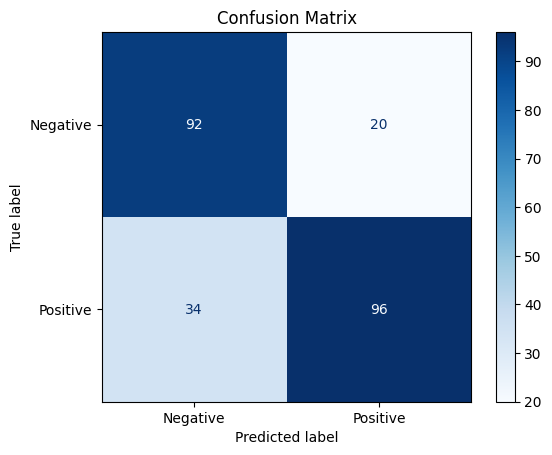

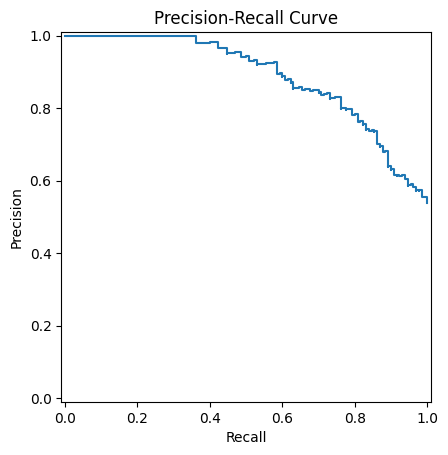


Selected Features (36):
['AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'LDELTOTAL_BL', 'TRABSCOR_bl', 'FAQ_bl', 'MOCA_bl', 'Ventricles_bl', 'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl', 'Hippocampus_ICV', 'Ventricles_ICV', 'Entorhinal_ICV', 'Fusiform_ICV', 'MidTemp_ICV', 'Hippocampus_MMSE', 'Ventricles_CDRSB', 'Entorhinal_ADAS13', 'APOE4_AGE', 'APOE4_EDUC', 'APOE4_Hippocampus', 'Executive_Composite', 'Memory_Decline', 'Learning_Efficiency']

Non-zero Coefficient Features:
APOE4_AGE                   1.864304
ADAS13_bl                   0.636471
Ventricles_CDRSB           -0.566890
MidTemp_ICV                -0.323325
Learning_Efficiency         0.311795
CDRSB_bl                    0.298736
PTGENDER                   -0.289344
APOE4_EDUC                 -0.276861
FAQ_bl                      0.264844
ICV_bl                     

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay

# Prepare data
X = df.drop(['tTau_Positive', 'tTau_ABETA_ratio'], axis=1)
y = df['tTau_Positive']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create pipeline with feature selection and tuned logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced'))),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Hyperparameter grid
param_grid = {
    'feature_selector__estimator__C': [0.01, 0.1, 1, 10],  # Controls feature selection strictness
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],  # Controls model regularization
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Grid search with AUC-ROC scoring
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Evaluate
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {grid_search.best_params_}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall curve (better for imbalanced data)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title('Precision-Recall Curve')
plt.show()

# Get selected features
selector = best_model.named_steps['feature_selector']
selected_features = X.columns[selector.get_support()]
print(f"\nSelected Features ({len(selected_features)}):")
print(selected_features.tolist())

# Feature importance
if best_model.named_steps['classifier'].penalty != 'l1':
    # For L2 regularization, show coefficients
    coefs = pd.Series(
        best_model.named_steps['classifier'].coef_[0],
        index=selected_features
    ).sort_values(key=abs, ascending=False)
    print("\nTop Features by Coefficient:")
    print(coefs.head(10))
else:
    # For L1, show non-zero features
    non_zero = np.abs(best_model.named_steps['classifier'].coef_[0]) > 0
    coefs = pd.Series(
        best_model.named_steps['classifier'].coef_[0][non_zero],
        index=selected_features[non_zero]
    ).sort_values(key=abs, ascending=False)
    print("\nNon-zero Coefficient Features:")
    print(coefs)

In [21]:
selected_features = ["APOE4_AGE","APOE4_EDUC ","ADAS13_bl","APOE4_Hippocampus", "Memory_Composite","ADAS11_bl","Ventricles_CDRSB",
                     "LDELTOTAL_BL","APOE4","Entorhinal_ADAS13","Hippocampus_MMSE","FAQ_bl","ADASQ4_bl","AGE","RAVLT_perc_forgetting_bl"]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 10, 'ccp_alpha': 0}

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       112
           1       0.80      0.72      0.76       130

    accuracy                           0.75       242
   macro avg       0.75      0.76      0.75       242
weighted avg       0.76      0.75      0.75       242


AUC-ROC: 0.849


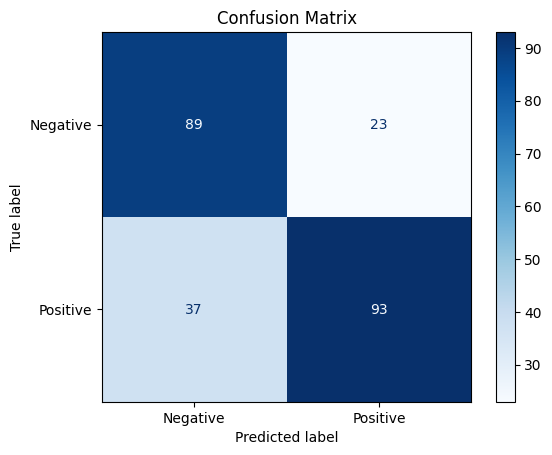

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Define clinically relevant features
selected_features = [
    "APOE4_AGE", "APOE4_EDUC", "ADAS13_bl", "APOE4_Hippocampus",
    "Memory_Composite", "ADAS11_bl", "Ventricles_CDRSB", "LDELTOTAL_BL",
    "APOE4", "Entorhinal_ADAS13", "Hippocampus_MMSE", "FAQ_bl",
    "ADASQ4_bl", "AGE", "RAVLT_perc_forgetting_bl"
]

# Prepare data - using only clinically relevant features
X = df[selected_features].copy()
y = df['tTau_Positive']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create simplified Random Forest pipeline
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced_subsample',
    n_jobs=-1
)

# Simplified hyperparameter grid for faster execution
param_grid = {
    'n_estimators': [100, 150],  # Reduced options
    'max_depth': [10, 15, 20],   # Shallower trees for interpretability
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 0.5],
    'ccp_alpha': [0, 0.01]       # Regularization for simplicity
}

# Randomized search with reduced iterations
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_grid,
    n_iter=20,  # Reduced from 50 to 20 for faster execution
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_

# Evaluate
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {random_search.best_params_}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

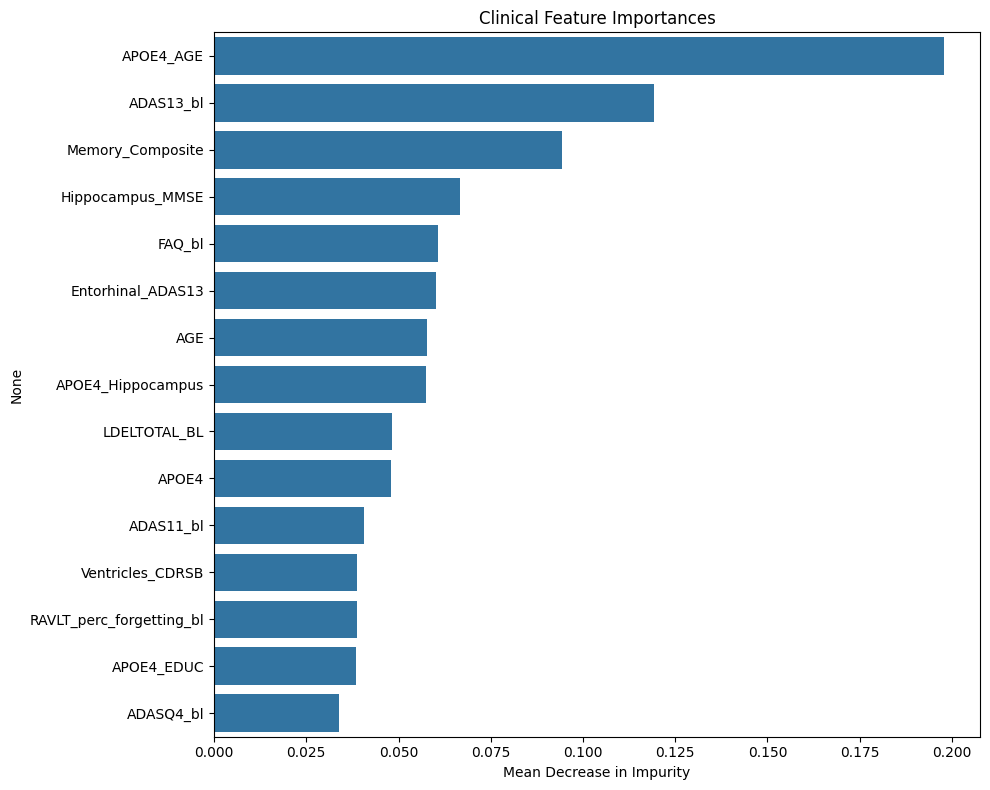

In [23]:
# Feature importance
feature_importances = pd.Series(
    best_rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Clinical Feature Importances')
plt.xlabel('Mean Decrease in Impurity')
plt.tight_layout()
plt.show()

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve

# Updated XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    tree_method='hist',
    enable_categorical=False,
    n_jobs=-1,
    scale_pos_weight=0.86  # updated from training set
)

# Focus on boosting recall or F1 for clinical utility
param_grid = {
    'n_estimators': [150, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.03, 0.05],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3]
}

random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_grid,
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',  # you can also try 'recall' to prioritize sensitivity
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_

# Predict probabilities and tune threshold
y_prob = best_xgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
optimal_threshold = thresholds[np.argmax(f1_scores)]

# Predict with tuned threshold
y_pred_opt = (y_prob >= optimal_threshold).astype(int)

# Evaluation
print(f"\nOptimal Threshold: {optimal_threshold:.2f}")
print(f"\nBest Parameters: {random_search.best_params_}")
print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt))
print(f"\nAUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits

Optimal Threshold: 0.30

Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.8}

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.82      0.70      0.75       112
           1       0.77      0.87      0.82       130

    accuracy                           0.79       242
   macro avg       0.79      0.78      0.78       242
weighted avg       0.79      0.79      0.79       242


AUC-ROC: 0.859


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:26:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


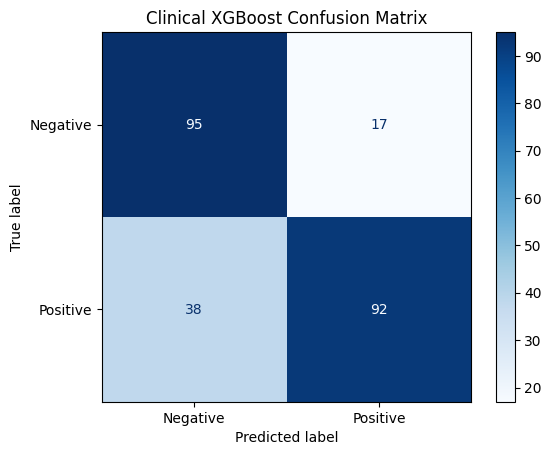

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Clinical XGBoost Confusion Matrix')
plt.show()

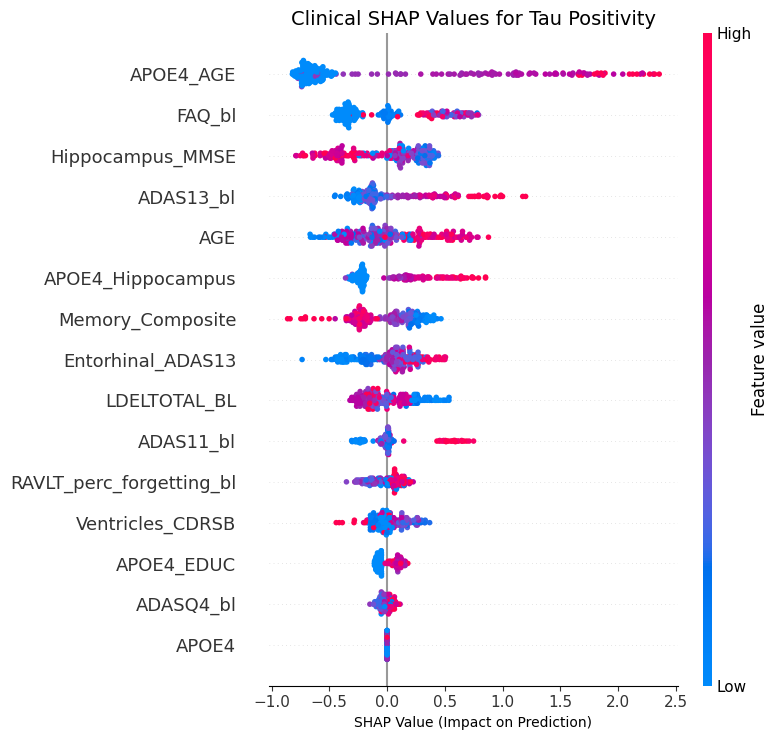

In [27]:
# ====== CLINICAL SHAP VISUALIZATIONS ====== #
# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_xgb)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# 1. Beeswarm plot for all clinical features
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot",
    show=False,
    max_display=15
)
plt.title("Clinical SHAP Values for Tau Positivity", fontsize=14)
plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=10)
plt.tight_layout()
plt.savefig("xgb_clinical_shap_summary.png", dpi=300, bbox_inches='tight')
plt.show()


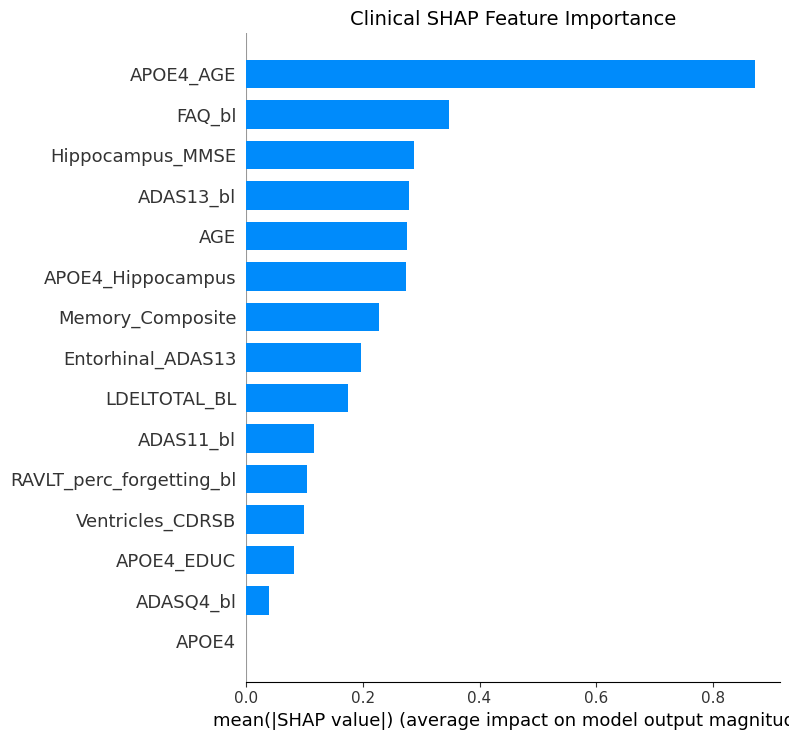

In [28]:
# 2. Bar plot of SHAP importance
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="bar",
    show=False
)
plt.title("Clinical SHAP Feature Importance", fontsize=14)
plt.tight_layout()
plt.savefig("xgb_clinical_shap_importance.png", dpi=300, bbox_inches='tight')
plt.show()

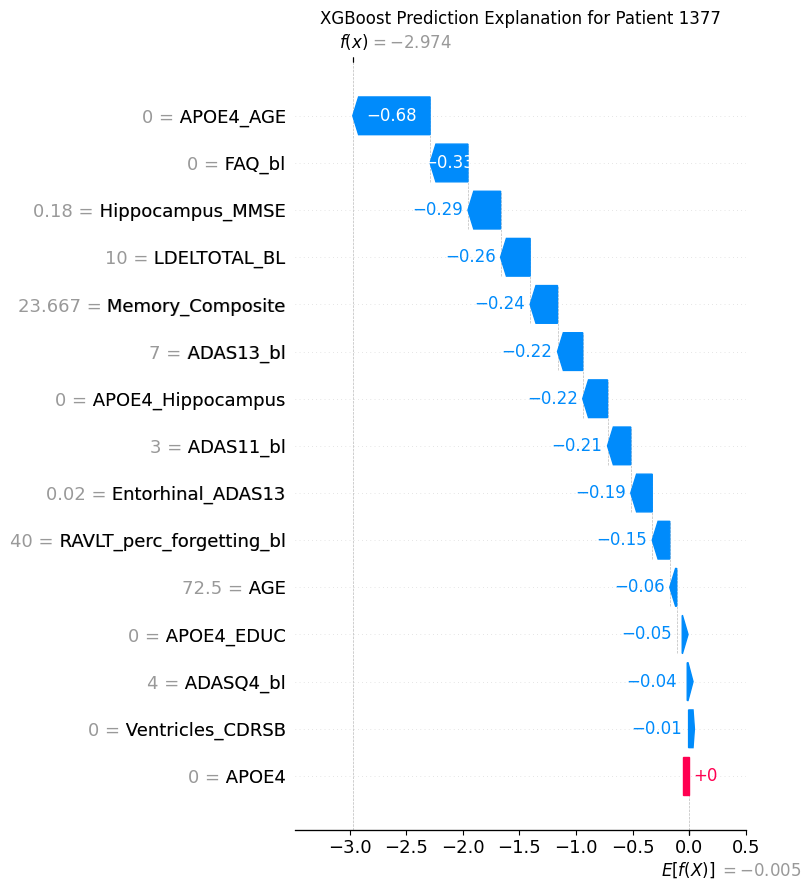

In [29]:
# 3. Individual patient explanations
sample_idx = 0  # First test sample

# Waterfall plot
plt.figure(figsize=(12, 6))
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[sample_idx],
    feature_names=X_test.columns.tolist()
), max_display=15, show=False)
plt.title(f"XGBoost Prediction Explanation for Patient {X_test.index[sample_idx]}", fontsize=12)
plt.tight_layout()
plt.savefig("xgb_clinical_waterfall_example.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 1000x600 with 0 Axes>

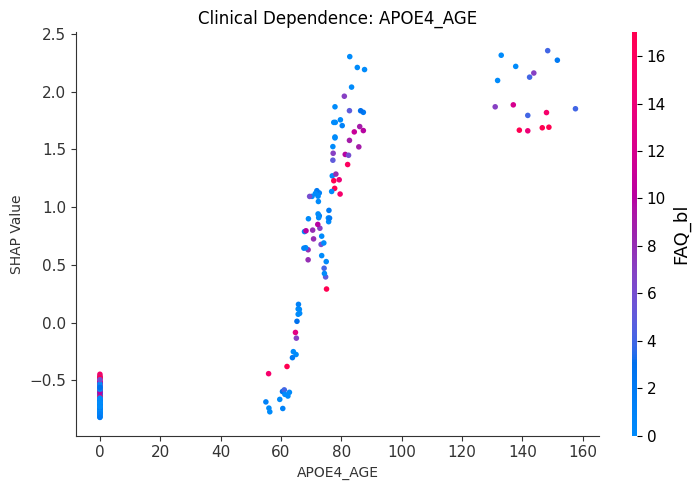

<Figure size 1000x600 with 0 Axes>

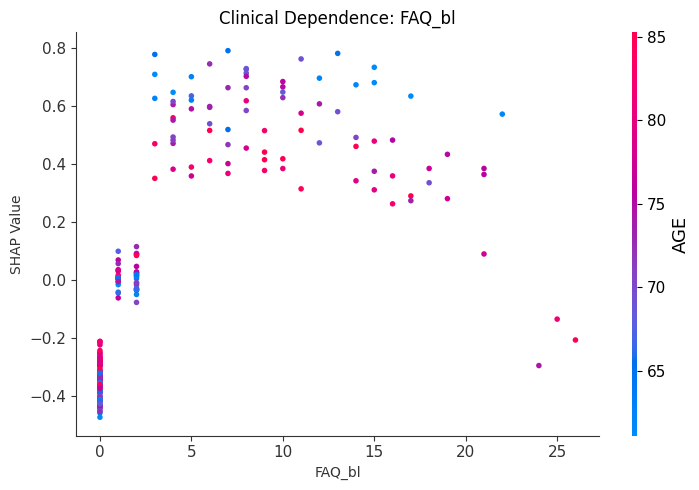

<Figure size 1000x600 with 0 Axes>

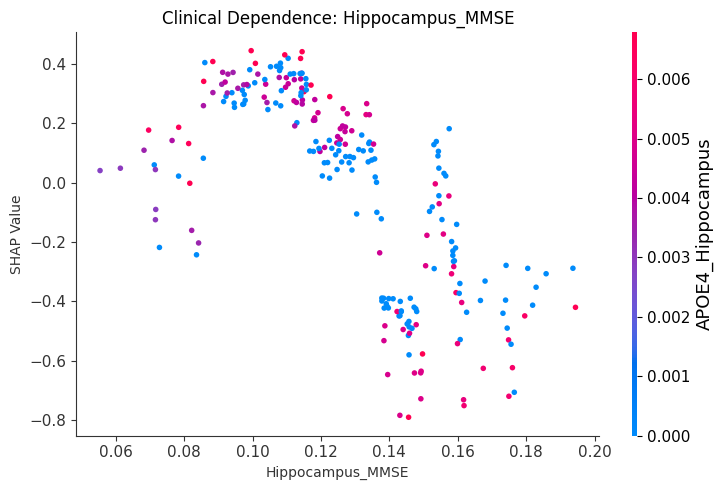

In [31]:
# 4. Dependence plots for key features
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
mean_abs_shap = shap_values_df.abs().mean().sort_values(ascending=False)
key_features = mean_abs_shap.index[:3]  # Top 3 features by SHAP impact

for feature in key_features:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        interaction_index='auto',
        show=False
    )
    plt.title(f"Clinical Dependence: {feature}", fontsize=12)
    plt.xlabel(feature, fontsize=10)
    plt.ylabel("SHAP Value", fontsize=10)
    plt.tight_layout()
    plt.savefig(f"xgb_clinical_dependence_{feature}.png", dpi=300, bbox_inches='tight')
    plt.show()


Class 0 (Negative) count: 446
Class 1 (Positive) count: 522

Classification Report (Default Threshold 0.5):
              precision    recall  f1-score   support

           0       0.72      0.79      0.76       112
           1       0.81      0.74      0.77       130

    accuracy                           0.76       242
   macro avg       0.77      0.77      0.76       242
weighted avg       0.77      0.76      0.76       242

AUC-ROC: 0.845

Optimal threshold for F2-score: 0.100
F2-score at this threshold: 0.842

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       112
           1       0.73      0.88      0.79       130

    accuracy                           0.76       242
   macro avg       0.77      0.75      0.75       242
weighted avg       0.77      0.76      0.75       242



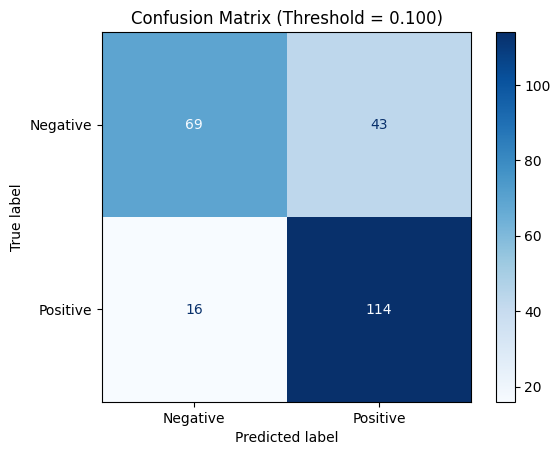


Clinical Performance Metrics:
Sensitivity (Recall): 0.877
Specificity: 0.616
PPV (Precision): 0.726
NPV: 0.812
F2-Score: 0.842
AUC-ROC: 0.845


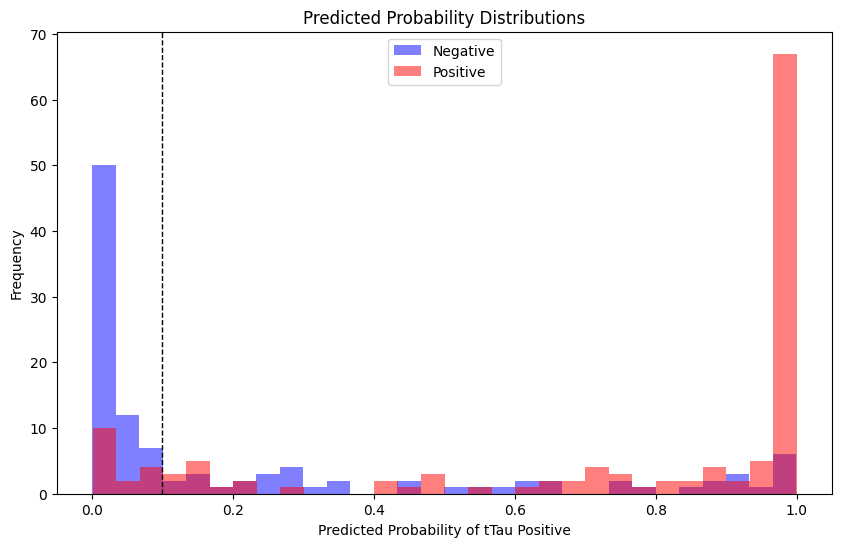

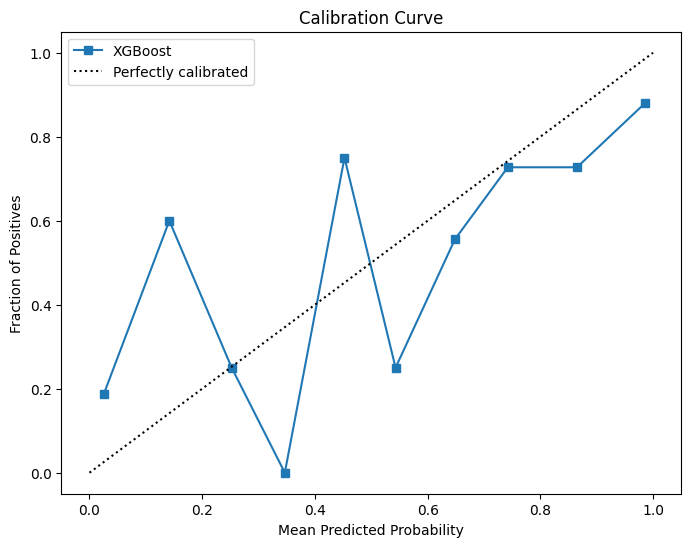

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.metrics import fbeta_score

# 1. Define features based on RF importance analysis
selected_features = [
    'APOE4_AGE', 'ADAS13_bl', 'Ventricles_CDRSB', 'Learning_Efficiency',
    'MidTemp_ICV', 'CDRSB_bl', 'PTGENDER', 'APOE4_EDUC', 'FAQ_bl', 'ICV_bl',
    'Hippocampus_MMSE', 'RAVLT_learning_bl', 'Executive_Composite',
    'RAVLT_perc_forgetting_bl', 'AGE', 'APOE4_Hippocampus', 'RAVLT_forgetting_bl',
    'LDELTOTAL_BL', 'Ventricles_ICV', 'MOCA_bl', 'Entorhinal_ADAS13',
    'WholeBrain_bl', 'MidTemp_bl', 'Fusiform_bl', 'Memory_Decline', 'PTEDUCAT'
]

# 2. Prepare data
X = df[selected_features].copy()
y = df['tTau_Positive']

# 3. Create essential interactions with checks
if 'APOE4_AGE' not in X.columns:
    X['APOE4_AGE'] = df['APOE4'] * df['AGE']
if 'Ventricles_CDRSB' not in X.columns:
    X['Ventricles_CDRSB'] = df['Ventricles_ICV'] * df['CDRSB_bl']
if 'APOE4_EDUC' not in X.columns:
    X['APOE4_EDUC'] = df['APOE4'] * df['PTEDUCAT']
if 'Hippocampus_MMSE' not in X.columns:
    X['Hippocampus_MMSE'] = df['Hippocampus_ICV'] * df['MMSE_bl']
if 'Executive_Composite' not in X.columns:
    X['Executive_Composite'] = (df['TRABSCOR_bl'] + df['FAQ_bl'] + df['MOCA_bl']) / 3
if 'APOE4_Hippocampus' not in X.columns:
    X['APOE4_Hippocampus'] = df['APOE4'] * df['Hippocampus_ICV']
if 'Learning_Efficiency' not in X.columns:
    X['Learning_Efficiency'] = df['RAVLT_learning_bl'] / df['RAVLT_immediate_bl']
if 'Memory_Decline' not in X.columns:
    X['Memory_Decline'] = df['RAVLT_immediate_bl'] - df['LDELTOTAL_BL']

# 4. Handle missing values
X = X.fillna(X.median())

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Calculate class weights
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_pos_weight = neg_count / pos_count
print(f"Class 0 (Negative) count: {neg_count}")
print(f"Class 1 (Positive) count: {pos_count}")

# 7. Create XGBoost model with balanced settings
xgb = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    tree_method='hist',
    n_jobs=-1
)

# 8. Use default parameters for better balance
# (Skip hyperparameter tuning to avoid overcomplicating)
xgb.fit(X_train, y_train)

# 9. Evaluate model
y_prob = xgb.predict_proba(X_test)[:, 1]
y_pred_default = xgb.predict(X_test)

print("\nClassification Report (Default Threshold 0.5):")
print(classification_report(y_test, y_pred_default))
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

# 10. Robust threshold optimization with F2-score
def find_optimal_threshold(y_true, y_prob):
    """Find threshold that maximizes F2-score (recall-focused)"""
    thresholds = np.linspace(0.1, 0.9, 50)  # Focus on reasonable range
    best_f2 = 0
    best_threshold = 0.5

    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        f2 = fbeta_score(y_true, y_pred, beta=2)  # Beta=2 weights recall higher

        if f2 > best_f2:
            best_f2 = f2
            best_threshold = thresh

    return best_threshold, best_f2

optimal_threshold, best_f2 = find_optimal_threshold(y_test, y_prob)
y_pred_optim = (y_prob >= optimal_threshold).astype(int)

print(f"\nOptimal threshold for F2-score: {optimal_threshold:.3f}")
print(f"F2-score at this threshold: {best_f2:.3f}")
print("\nClassification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_optim))

# 11. Confusion matrix
cm = confusion_matrix(y_test, y_pred_optim)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold:.3f})')
plt.show()

# 12. Clinical performance metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print("\nClinical Performance Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"PPV (Precision): {ppv:.3f}")
print(f"NPV: {npv:.3f}")
print(f"F2-Score: {best_f2:.3f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.3f}")

# 13. Plot probability distributions
plt.figure(figsize=(10, 6))
plt.hist(y_prob[y_test == 0], bins=30, alpha=0.5, label='Negative', color='blue')
plt.hist(y_prob[y_test == 1], bins=30, alpha=0.5, label='Positive', color='red')
plt.axvline(optimal_threshold, color='k', linestyle='dashed', linewidth=1)
plt.title('Predicted Probability Distributions')
plt.xlabel('Predicted Probability of tTau Positive')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 14. Calibration curve
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, 's-', label='XGBoost')
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

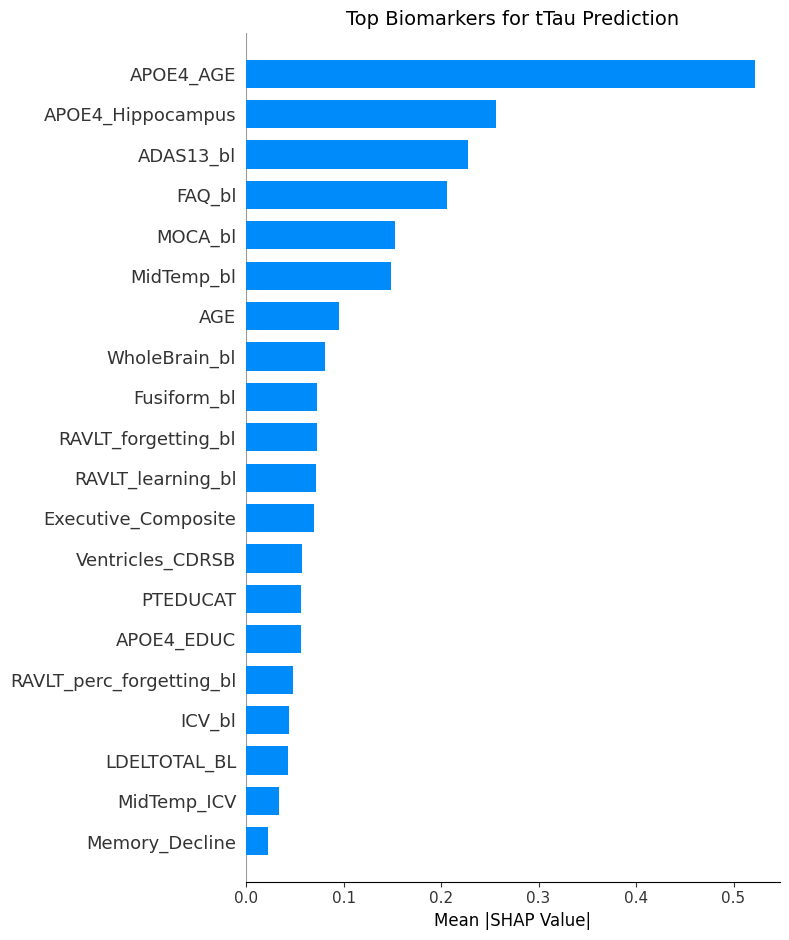

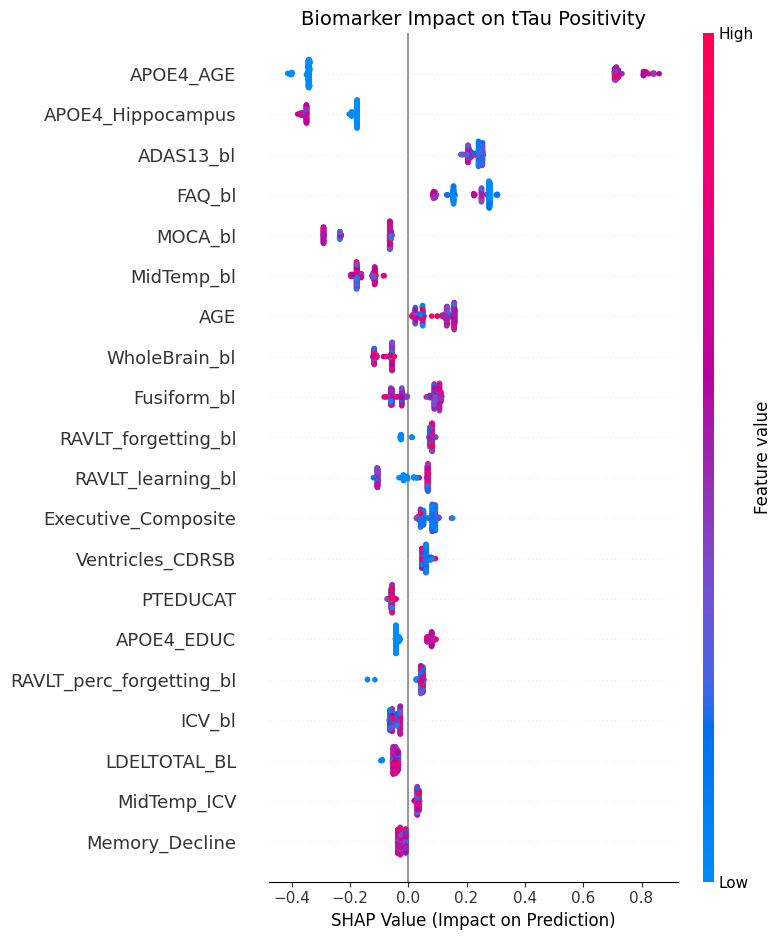

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Initialize SHAP explainer
explainer = shap.TreeExplainer(best_xgb)

# Calculate SHAP values using a representative sample
sample_size = min(200, len(X_test))  # Use up to 200 samples
sample_idx = np.random.choice(X_test.index, size=sample_size, replace=False)
X_sample = X_test.loc[sample_idx]
shap_values = explainer.shap_values(X_sample)

# 1. Feature Importance Plot (Critical)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Top Biomarkers for tTau Prediction", fontsize=14)
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.tight_layout()
plt.savefig('shap_feature_importance.png', dpi=300)
plt.show()

# 2. Impact Direction Plot (Essential)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("Biomarker Impact on tTau Positivity", fontsize=14)
plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=12)
plt.tight_layout()
plt.savefig('shap_impact_direction.png', dpi=300)
plt.show()
